<h2 style="text-align:center;">Loan Approval Intelligence — End‑to‑End Modeling Notebook</h2>

**Author:** Your Name  
**Date:** 2025-10-03  
**Goal:** Build a robust, reproducible machine learning pipeline to predict **Loan Approval** (Approved = 1, Rejected = 0) and export a **production‑ready** model + assets for the Flask/Streamlit app.

### What you'll get by the end
- Cleaned dataset + engineered features
- Reproducible preprocessing via `ColumnTransformer` + `Pipeline`
- Multiple models benchmarked with cross‑validation
- Clear evaluation: Accuracy, Precision, Recall, F1, ROC‑AUC
- Plots: Confusion Matrix, ROC Curve, (optional) Feature Importance
- Saved artifacts: `best_model.pkl`, `metrics.json`, `metrics_table.csv`, plots, and `example_predictions.csv`

**Folders expected (relative to this notebook inside `notebook/`):**
```
../data/Loan_Data.csv
../results/
../app/models/
```


<h2 style="text-align:center;">1) Imports & Configuration</h2>

In [1]:
# ➤ Standard imports
import os
import json
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

# ➤ Visualization (use matplotlib as default)
import matplotlib.pyplot as plt

# ➤ Modeling
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

# ➤ Metrics
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, classification_report, RocCurveDisplay)

# ➤ Persistence
import joblib

# ➤ Try importing XGBoost, fall back gracefully if not installed
try:
    from xgboost import XGBClassifier
    XGB_AVAILABLE = True
except Exception:
    XGB_AVAILABLE = False

# ➤ Paths (notebook is in ./notebook/)
DATA_PATH = '../data/Loan_Data.csv'
RESULTS_DIR = '../results'
MODELS_DIR = '../app/models'

# Ensure output folders exist
os.makedirs(RESULTS_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)


<h2 style="text-align:center;">2) Load Data & Quick Overview</h2>

In [2]:
# ➤ Load the dataset
df = pd.read_csv(DATA_PATH)

# ➤ Show basic info
print('Shape:', df.shape)  # ➤
display(df.head(5))        # ➤
print('\nData types:')     # ➤
print(df.dtypes)

# ➤ Check missing values
print('\nMissing values per column:')  # ➤
print(df.isna().sum())


Shape: (614, 13)


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y



Data types:
Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

Missing values per column:
Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64


<h2 style="text-align:center;">3) Basic Cleaning & Target Mapping</h2>

In [3]:
# ➤ Drop unique identifier columns if present
id_cols = [c for c in df.columns if c.lower() in ['loan_id', 'id']]
df = df.drop(columns=id_cols, errors='ignore')

# ➤ Standardize target to 0/1
# Common target values: 'Y'/'N' or 1/0
if 'Loan_Status' in df.columns:
    if df['Loan_Status'].dtype == 'O':
        df['Loan_Status'] = df['Loan_Status'].str.strip().str.upper().map({'Y':1, 'N':0})
    # If already numeric, ensure it's int
    df['Loan_Status'] = df['Loan_Status'].astype('Int64').astype(int)
else:
    raise ValueError("Target column 'Loan_Status' not found in dataset.")

# ➤ Basic feature engineering: total Income and Loan-to-Income ratio
if set(['ApplicantIncome','CoapplicantIncome']).issubset(df.columns):
    df['Income'] = df['ApplicantIncome'].fillna(0) + df['CoapplicantIncome'].fillna(0)
else:
    # If columns are different, adjust as needed
    raise ValueError("Expected columns 'ApplicantIncome' and 'CoapplicantIncome' missing.")

if 'LoanAmount' in df.columns:
    # Some datasets store LoanAmount as thousands; we assume unit is as in file
    # Fill missing later via pipeline, but create safe ratio column
    df['Loan_to_Income'] = df['LoanAmount'] / (df['Income'].replace(0, np.nan))
else:
    raise ValueError("Expected column 'LoanAmount' missing.")

# ➤ Convert 'Dependents' like '3+' to numeric 3 (if present)
if 'Dependents' in df.columns and df['Dependents'].dtype == 'O':
    df['Dependents'] = df['Dependents'].str.replace('+','', regex=False)
    df['Dependents'] = pd.to_numeric(df['Dependents'], errors='coerce')

print('Columns after basic cleaning/engineering:', list(df.columns))  # ➤
display(df.head(5))  # ➤


Columns after basic cleaning/engineering: ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status', 'Income', 'Loan_to_Income']


,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Income,Loan_to_Income
0,Male,No,0.0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,1,5849.0,NaN
1,Male,Yes,1.0,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,0,6091.0,0.021015
2,Male,Yes,0.0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,1,3000.0,0.022000
3,Male,Yes,0.0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,1,4941.0,0.024287
4,Male,No,0.0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,1,6000.0,0.023500


<h2 style="text-align:center;">4) Exploratory Data Analysis (EDA)</h2>

We’ll inspect distributions and target balance.  
*Note:* For a concise notebook, we’ll show a few core plots.

Target counts (0=Rejected, 1=Approved):
Loan_Status
0    192
1    422
Name: count, dtype: int64


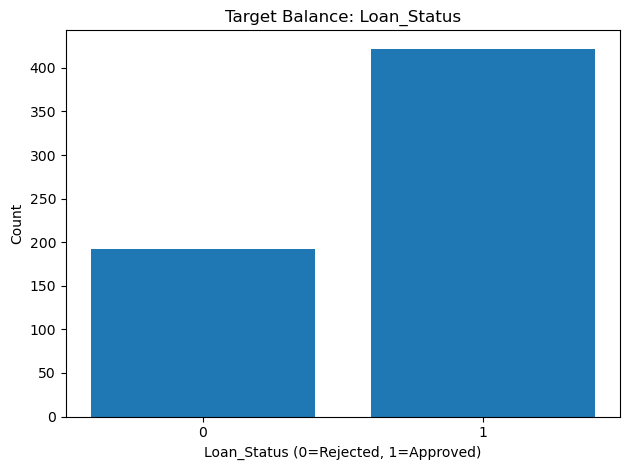

<Figure size 640x480 with 0 Axes>

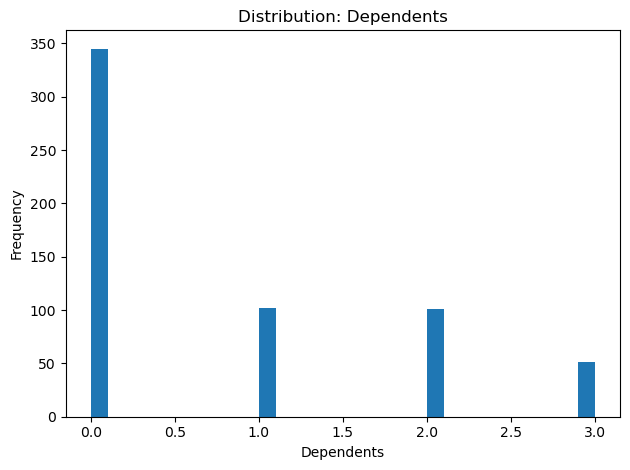

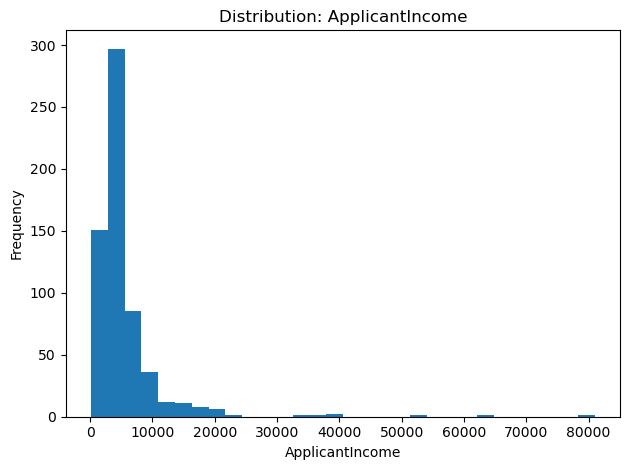

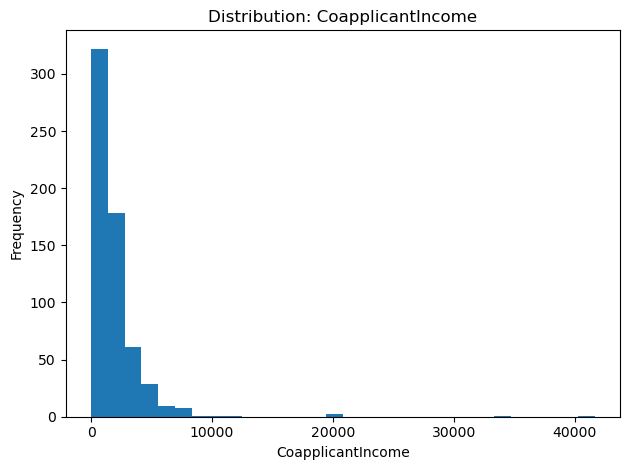

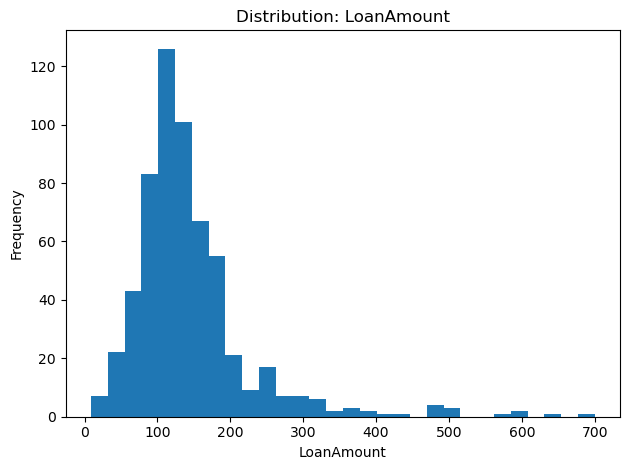

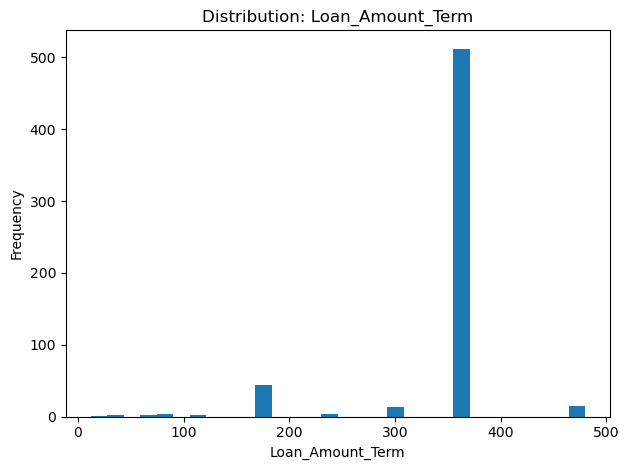

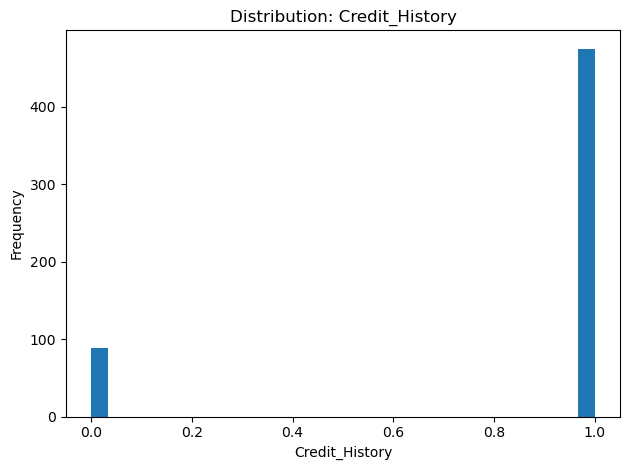

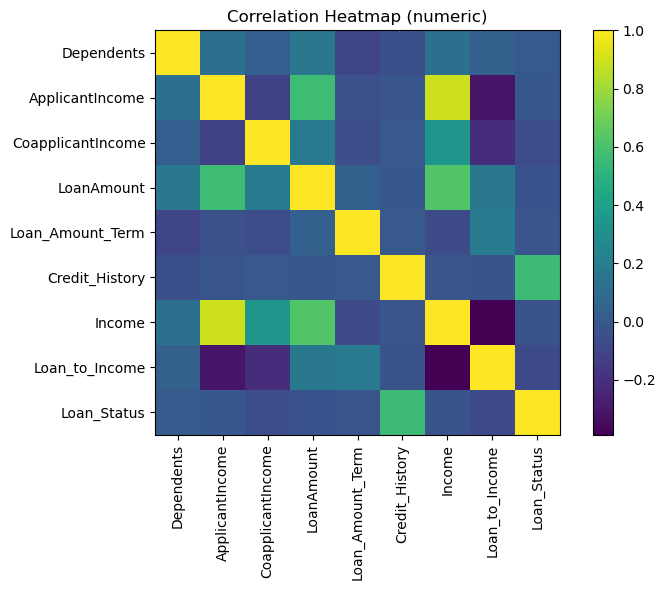

In [4]:
# ➤ Target balance
target_counts = df['Loan_Status'].value_counts().sort_index()
print('Target counts (0=Rejected, 1=Approved):')  # ➤
print(target_counts)

plt.figure()
plt.bar(target_counts.index.astype(str), target_counts.values)
plt.title('Target Balance: Loan_Status')
plt.xlabel('Loan_Status (0=Rejected, 1=Approved)')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig(f"{RESULTS_DIR}/target_balance.png", dpi=200)
plt.show()

# ➤ Numeric distributions
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c != 'Loan_Status']

plt.figure()
for i, col in enumerate(numeric_cols[:6], start=1):
    plt.figure()
    plt.hist(df[col].dropna(), bins=30)
    plt.title(f'Distribution: {col}')
    plt.xlabel(col); plt.ylabel('Frequency')
    plt.tight_layout()
plt.show()

# ➤ Simple correlation heatmap for numeric features (matplotlib-only)
corr = df[numeric_cols + ['Loan_Status']].corr(numeric_only=True)
plt.figure(figsize=(8,6))
plt.imshow(corr, interpolation='nearest')
plt.title('Correlation Heatmap (numeric)')
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)
plt.colorbar()
plt.tight_layout()
plt.savefig(f"{RESULTS_DIR}/correlation_heatmap.png", dpi=200)
plt.show()


<h2 style="text-align:center;">5) Preprocessing: ColumnTransformer + Pipeline</h2>

In [5]:
# ➤ Define features and target
target = 'Loan_Status'
X = df.drop(columns=[target])
y = df[target].values

# ➤ Identify column types
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

print('Numeric features:', numeric_features)  # ➤
print('Categorical features:', categorical_features)  # ➤

# ➤ Preprocessors
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# ➤ Train / Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)  # ➤


Numeric features: ['Dependents', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'Income', 'Loan_to_Income']
Categorical features: ['Gender', 'Married', 'Education', 'Self_Employed', 'Property_Area']
Train shape: (491, 13) Test shape: (123, 13)


<h2 style="text-align:center;">6) Modeling: Baselines & Tuned Models</h2>

In [6]:
# ➤ Define candidate models with modest grids (kept small for runtime)
models_and_params = {
    'LogReg': (LogisticRegression(max_iter=200, random_state=RANDOM_STATE),
               {'clf__C':[0.1, 1.0, 10.0]}),
    'KNN': (KNeighborsClassifier(),
            {'clf__n_neighbors':[3,5,7]}),
    'SVC': (SVC(probability=True, random_state=RANDOM_STATE),
            {'clf__C':[0.5,1.0,2.0], 'clf__kernel':['rbf','linear']}),
    'DT': (DecisionTreeClassifier(random_state=RANDOM_STATE),
           {'clf__max_depth':[3,5,7,10]}),
    'RF': (RandomForestClassifier(random_state=RANDOM_STATE),
           {'clf__n_estimators':[100,200], 'clf__max_depth':[None,5,10]}),
    'Ada': (AdaBoostClassifier(random_state=RANDOM_STATE),
            {'clf__n_estimators':[100,200], 'clf__learning_rate':[0.5,1.0]}),
    'GB': (GradientBoostingClassifier(random_state=RANDOM_STATE),
           {'clf__n_estimators':[100,200], 'clf__learning_rate':[0.05,0.1]}),
}

if XGB_AVAILABLE:
    models_and_params['XGB'] = (
        XGBClassifier(random_state=RANDOM_STATE, eval_metric='logloss', use_label_encoder=False),
        {'clf__n_estimators':[150,250], 'clf__max_depth':[3,5]}
    )

results = []
best_estimators = {}

# ➤ Iterate and grid-search each model within a Pipeline(preprocessor + clf)
for name, (estimator, param_grid) in models_and_params.items():
    print(f"\n=== {name} ===")
    pipe = Pipeline(steps=[('preprocessor', preprocessor), ('clf', estimator)])
    grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1)
    grid.fit(X_train, y_train)
    best_estimators[name] = grid.best_estimator_

    # CV performance on train via best params
    y_pred_val = grid.predict(X_test)
    if hasattr(grid, 'predict_proba'):
        y_proba_val = grid.predict_proba(X_test)[:,1] if hasattr(grid.best_estimator_['clf'], 'predict_proba') else None
    # Safely fetch predict_proba from the pipeline
    try:
        y_proba_val = grid.best_estimator_.predict_proba(X_test)[:,1]
    except Exception:
        # Some models (like SVC with linear kernel) may not expose it
        y_proba_val = None

    acc = accuracy_score(y_test, y_pred_val)
    prec = precision_score(y_test, y_pred_val, zero_division=0)
    rec = recall_score(y_test, y_pred_val, zero_division=0)
    f1 = f1_score(y_test, y_pred_val, zero_division=0)
    roc = roc_auc_score(y_test, y_proba_val) if y_proba_val is not None else np.nan

    results.append({
        'model': name,
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'roc_auc': roc
    })

# ➤ Create metrics table
metrics_df = pd.DataFrame(results).sort_values(by=['f1','roc_auc'], ascending=False)
display(metrics_df)

# Save metrics table
metrics_df.to_csv(f"{RESULTS_DIR}/metrics_table.csv", index=False)

# Save metrics json (topline)
metrics_json = metrics_df.to_dict(orient='records')
with open(f"{RESULTS_DIR}/metrics.json", 'w') as f:
    json.dump(metrics_json, f, indent=2)



=== LogReg ===

=== KNN ===

=== SVC ===

=== DT ===

=== RF ===

=== Ada ===

=== GB ===

=== XGB ===


,model,accuracy,precision,recall,f1,roc_auc
4,RF,0.869919,0.848485,0.988235,0.913043,0.873994
0,LogReg,0.861789,0.840000,0.988235,0.908108,0.872446
1,KNN,0.861789,0.846939,0.976471,0.907104,0.844427
6,GB,0.853659,0.852632,0.952941,0.900000,0.850000
2,SVC,0.845528,0.823529,0.988235,0.898396,0.865015
5,Ada,0.853659,0.885057,0.905882,0.895349,0.847678
3,DT,0.845528,0.843750,0.952941,0.895028,0.806502
7,XGB,0.813008,0.860465,0.870588,0.865497,0.815480


<h2 style="text-align:center;">7) Best Model Selection & Evaluation</h2>

Best model: RF
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Dependents',
                                                   'ApplicantIncome',
                                                   'CoapplicantIncome',
                                                   'LoanAmount',
                                                   'Loan_Amount_Term',
                                                   'Credit_History', 'Income',
                                                   'Loan_to_Income']),
                                                 ('cat',


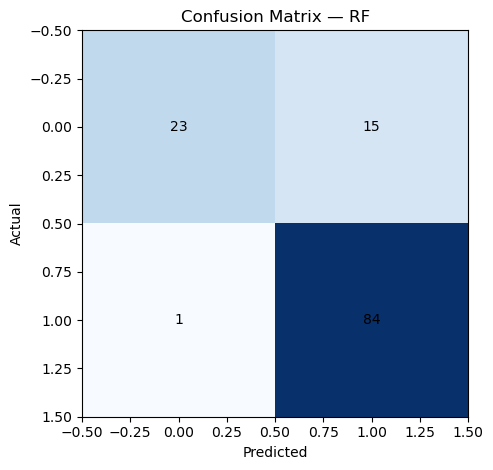

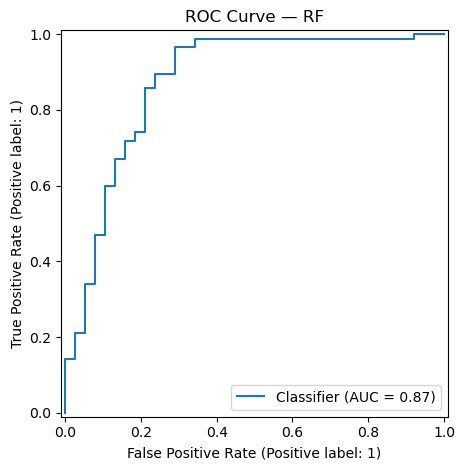

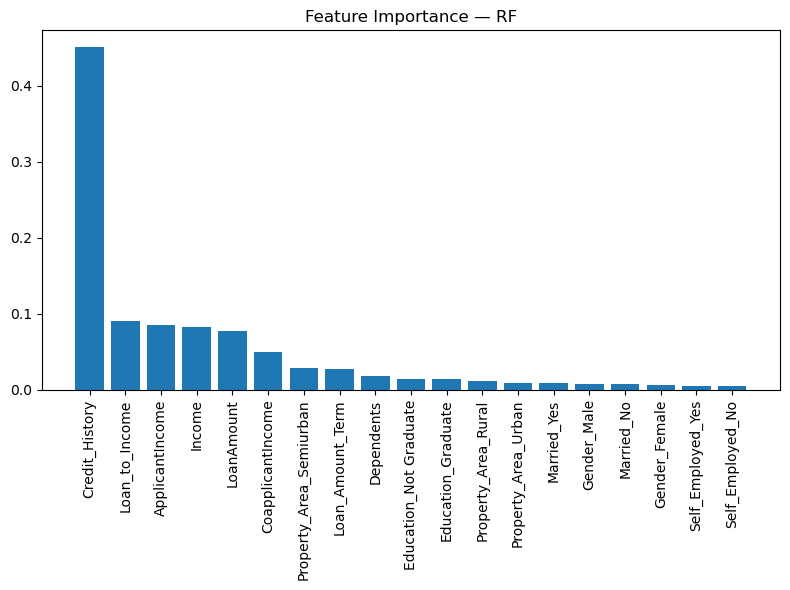

In [7]:
# ➤ Pick best by F1, then ROC-AUC fallback
best_row = metrics_df.sort_values(by=['f1','roc_auc'], ascending=[False, False]).iloc[0]
best_name = best_row['model']
best_model = best_estimators[best_name]

print(f"Best model: {best_name}")  # ➤
print(best_model)                  # ➤

# ➤ Final evaluation on test set
y_pred = best_model.predict(X_test)

# Try for probabilities
try:
    y_proba = best_model.predict_proba(X_test)[:,1]
except Exception:
    y_proba = None

print('\nClassification Report (Test):')  # ➤
print(classification_report(y_test, y_pred, digits=4))

# ➤ Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure()
plt.imshow(cm, cmap='Blues')
plt.title(f'Confusion Matrix — {best_name}')
plt.xlabel('Predicted'); plt.ylabel('Actual')
for (i, j), v in np.ndenumerate(cm):
    plt.text(j, i, str(v), ha='center', va='center')
plt.tight_layout()
plt.savefig(f"{RESULTS_DIR}/confusion_matrix.png", dpi=200)
plt.show()

# ➤ ROC Curve (if probs available)
if y_proba is not None:
    RocCurveDisplay.from_predictions(y_test, y_proba)
    plt.title(f'ROC Curve — {best_name}')
    plt.tight_layout()
    plt.savefig(f"{RESULTS_DIR}/roc_curve.png", dpi=200)
    plt.show()

# ➤ Optional: Feature Importance (tree-based)
def plot_feature_importance(model, preprocessor, feature_names_out, title):
    try:
        # Try to access underlying estimator
        clf = model.named_steps['clf']
        importances = None

        if hasattr(clf, 'feature_importances_'):
            importances = clf.feature_importances_
        elif hasattr(clf, 'coef_'):
            # For linear models, take absolute coefficients as importance
            coefs = np.ravel(clf.coef_) if hasattr(clf, 'coef_') else None
            importances = np.abs(coefs) if coefs is not None else None

        if importances is not None:
            idx = np.argsort(importances)[::-1][:20]  # top 20
            plt.figure(figsize=(8,6))
            plt.bar(range(len(idx)), importances[idx])
            plt.xticks(range(len(idx)), [feature_names_out[i] for i in idx], rotation=90)
            plt.title(title)
            plt.tight_layout()
            plt.savefig(f"{RESULTS_DIR}/feature_importance.png", dpi=200)
            plt.show()
    except Exception as e:
        print('Feature importance not available:', e)  # ➤

# Build feature names after preprocessing
try:
    # Fit preprocessor alone to training data to get feature names
    pre = best_model.named_steps['preprocessor']
    pre.fit(X_train)

    # Get feature names (numeric + onehot)
    num_feats = pre.transformers_[0][2]
    cat_feats = pre.transformers_[1][2]

    # OneHotEncoder feature names
    ohe = pre.named_transformers_['cat'].named_steps['onehot']
    ohe_feature_names = ohe.get_feature_names_out(cat_feats)

    feature_names_out = np.r_[num_feats, ohe_feature_names]
    plot_feature_importance(best_model, pre, feature_names_out, f'Feature Importance — {best_name}')
except Exception as e:
    print('Could not compute feature names / importance:', e)  # ➤


<h2 style="text-align:center;">8) Save Artifacts (Model, Metrics, Examples, Plots)</h2>

In [8]:
# ➤ Save best model pipeline as a single .pkl (includes preprocessing)
model_path = f"{MODELS_DIR}/best_model.pkl"
joblib.dump(best_model, model_path)
print('Saved best model to:', model_path)  # ➤

# ➤ Create example predictions from a small sample
sample = X_test.copy()
sample[target] = y_test
sample_pred = sample.copy()
sample_pred['prediction'] = y_pred
if y_proba is not None:
    sample_pred['pred_proba'] = y_proba

# Save a small subset
sample_pred.head(50).to_csv(f"{RESULTS_DIR}/example_predictions.csv", index=False)
print('Saved example predictions to results/example_predictions.csv')  # ➤


Saved best model to: ../app/models/best_model.pkl
Saved example predictions to results/example_predictions.csv


<h2 style="text-align:center;">9) Conclusion & Next Steps</h2>

**Summary:**  
- Built a robust pipeline with clean preprocessing and multiple models.  
- Selected the best model using cross‑validated grid search (by F1, ROC‑AUC).  
- Exported a production‑ready pipeline (`best_model.pkl`) and saved evaluation assets.

**Next Steps / Enhancements:**  
- Conduct calibration for probabilities (Platt/Isotonic).  
- Add fairness checks (demographic parity, equal opportunity) if sensitive attributes exist.  
- Log predictions & feedback to a DB to close the loop (MLOps).  
- Try more advanced models and SHAP for interpretability.
